### Importing the Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import json # library to handle JSON files
import geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
import seaborn as sns; sns.set_theme()

### Preparing the credentials

In [2]:
CLIENT_ID = 'NY3ZRAH4FQ5VUKNULWWDIZJXQBQTTOOUDA4FXYF2ZO2A4WNO' # your Foursquare ID
CLIENT_SECRET = 'QXLLKB33OEE3QCS0FF5DWRVZDETBGETIABUDBVK4V1ZTK3JM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NY3ZRAH4FQ5VUKNULWWDIZJXQBQTTOOUDA4FXYF2ZO2A4WNO
CLIENT_SECRET:QXLLKB33OEE3QCS0FF5DWRVZDETBGETIABUDBVK4V1ZTK3JM


### Loading the Data

In [3]:
df = pd.read_csv("Bairros.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Bairro  41 non-null     object 
 1   Lat     0 non-null      float64
 2   Long    0 non-null      float64
dtypes: float64(2), object(1)
memory usage: 1.1+ KB


In [5]:
df.head()

,Bairro,Lat,Long
0,Adhemar Garcia,NaN,NaN
1,América,NaN,NaN
2,Anita Garibaldi,NaN,NaN
3,Atiradores,NaN,NaN
4,Aventureiro,NaN,NaN


### Getting the Geographical Coordinates for all my Neighbourhoods

In [6]:
for index, row in df.iterrows():
    #print(row['Bairro'])
    address = row['Bairro'] + ", Joinville Brazil"

    geolocator = Nominatim(user_agent="explorer")
    location = geolocator.geocode(address)
    df['Lat'].iloc[index] = location.latitude
    latitude = location.latitude
    df['Long'].iloc[index] = location.longitude
    longitude = location.longitude
#   print(f'The geograpical coordinate of {address} are {latitude}, {longitude}.')
    
#    print(df['Lat'].iloc[index])
#    print(df['Long'].iloc[index])

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [7]:
df.head()

,Bairro,Lat,Long
0,Adhemar Garcia,-26.321731,-48.801844
1,América,-26.290361,-48.853581
2,Anita Garibaldi,-26.318420,-48.856278
3,Atiradores,-26.310171,-48.863780
4,Aventureiro,-26.243548,-48.810468


### Creating a Visual Representation from my Data

In [8]:
# create map of New York using latitude and longitude values
map_jlle = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, bairro in zip(df['Lat'], df['Long'], df['Bairro']):
    label = '{}'.format(bairro)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_jlle)  
    
map_jlle

### Creating variables for Foursquare API

bairro_latitude = df.loc[0, 'Lat'] # neighborhood latitude value
bairro_longitude = df.loc[0, 'Long'] # neighborhood longitude value

nome_bairro = df.loc[0, 'Bairro'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(nome_bairro, 
                                                               bairro_latitude, 
                                                               bairro_longitude))

### Creating the Foursquare URL

LIMIT = 100 # number of venues

radius = 500 # radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    bairro_latitude, 
    bairro_longitude, 
    radius, 
    LIMIT)
url # display URL

### Retrieving the Data From Foursquare

results = requests.get(url).json()
results

### Creating a function to extract the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Using the function to create a DataFrame with the Name, Category and Coordinates

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

In [9]:
def getNearbyVenues(nomes, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for nome, lat, lng in zip(nomes, latitudes, longitudes):
        print(nome)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            nome, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
dt_venues = getNearbyVenues(nomes=df['Bairro'],
                                   latitudes=df['Lat'],
                                   longitudes=df['Long']
                                  )

Adhemar Garcia
América
Anita Garibaldi
Atiradores
Aventureiro
Boa Vista
Boehmerwald
Bom Retiro
Bucarein
Centro
Comasa
Costa e Silva
Espinheiros
Fátima
Floresta
Glória
Guanabara
Iririú
Itaum
Itinga
Parque Guarani
Jardim Iririú
Jardim Paraíso
Jarivatuba
Jativoca
João Costa
Morro do Meio
Nova Brasília
Paranaguamirim
Petrópolis
Pirabeiraba
Profipo
Saguaçu
Santa Catarina
Santo Antônio
São Marcos
Ulysses Guimarães
Vila Cubatão
Vila Nova
Zona Industrial Norte
Zona Industrial Tupy


In [11]:
print(dt_venues.shape)
dt_venues.head()

(243, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adhemar Garcia,-26.321731,-48.801844,Peto Lanches,-26.318336,-48.803473,Diner
1,Adhemar Garcia,-26.321731,-48.801844,Supermercado Ponto Certo III,-26.322744,-48.799070,Market
2,Adhemar Garcia,-26.321731,-48.801844,Novo Parque São Francisco,-26.321943,-48.805312,Theme Park Ride / Attraction
3,Adhemar Garcia,-26.321731,-48.801844,Parque Natural Municipal da Caieira,-26.322202,-48.805852,Park
4,Adhemar Garcia,-26.321731,-48.801844,restaurante lai lai,-26.325575,-48.803196,Chinese Restaurant


In [12]:
dt_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adhemar Garcia,5,5,5,5,5,5
América,19,19,19,19,19,19
Anita Garibaldi,9,9,9,9,9,9
Atiradores,5,5,5,5,5,5
Aventureiro,3,3,3,3,3,3
Boa Vista,11,11,11,11,11,11
Boehmerwald,10,10,10,10,10,10
Bom Retiro,9,9,9,9,9,9
Bucarein,18,18,18,18,18,18


In [13]:
print('There are {} uniques categories.'.format(len(dt_venues['Venue Category'].unique())))

There are 98 uniques categories.


In [14]:
# one hot encoding
dt_onehot = pd.get_dummies(dt_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dt_onehot['Neighborhood'] = dt_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dt_onehot.columns[-1]] + list(dt_onehot.columns[:-1])
dt_onehot = dt_onehot[fixed_columns]

dt_onehot.head()

,Neighborhood,Acai House,Accessories Store,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,Auto Workshop,BBQ Joint,Bakery,Bar,Beer Garden,Big Box Store,Bistro,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Burger Joint,Bus Station,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Churrascaria,Clothing Store,Coffee Shop,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Farmers Market,Fast Food Restaurant,Flower Shop,Food Truck,Football Stadium,French Restaurant,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gastropub,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Hospital,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Juice Bar,Kids Store,Light Rail Station,Liquor Store,Lottery Retailer,Market,Martial Arts School,Mediterranean Restaurant,Miscellaneous Shop,Motorcycle Shop,Mountain,Nightclub,Noodle House,Other Great Outdoors,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Pub,Recording Studio,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Sporting Goods Shop,Steakhouse,Supermarket,Tea Room,Theme Park Ride / Attraction,Track,Vegetarian / Vegan Restaurant,Video Store,Warehouse Store,Wine Bar
0,Adhemar Garcia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adhemar Garcia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Adhemar Garcia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,Adhemar Garcia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Adhemar Garcia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
dt_onehot.shape

(243, 99)

#### Creating a Dataframe containing the Mean Venues/Neighbourhood

In [16]:
dt_grouped = dt_onehot.groupby('Neighborhood').mean().reset_index()
dt_grouped

,Neighborhood,Acai House,Accessories Store,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,Auto Workshop,BBQ Joint,Bakery,Bar,Beer Garden,Big Box Store,Bistro,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Burger Joint,Bus Station,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Churrascaria,Clothing Store,Coffee Shop,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Farmers Market,Fast Food Restaurant,Flower Shop,Food Truck,Football Stadium,French Restaurant,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gastropub,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Hospital,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Juice Bar,Kids Store,Light Rail Station,Liquor Store,Lottery Retailer,Market,Martial Arts School,Mediterranean Restaurant,Miscellaneous Shop,Motorcycle Shop,Mountain,Nightclub,Noodle House,Other Great Outdoors,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Pub,Recording Studio,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Sporting Goods Shop,Steakhouse,Supermarket,Tea Room,Theme Park Ride / Attraction,Track,Vegetarian / Vegan Restaurant,Video Store,Warehouse Store,Wine Bar
0,Adhemar Garcia,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.000000,0.000000
1,América,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.052632,0.000000,0.000000,0.000000,0.0,0.052632,0.0,0.000000,0.000000,0.000000,0.052632,0.000000,0.052632,0.0,0.052632,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.052632,0.052632,0.0,0.052632,0.000000,0.000000,0.052632,0.0,0.000000,0.052632,0.000000,0.000000,0.000000,0.0,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.105263,0.052632,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.052632,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.052632
2,Anita Garibaldi,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.111111,0.111111,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.0,0.000000,0.111111,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.111111,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.111111,0.000000,0.000000,0.000000,0.000000
3,Atiradores,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000

In [17]:
dt_grouped.describe()

,Acai House,Accessories Store,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,Auto Workshop,BBQ Joint,Bakery,Bar,Beer Garden,Big Box Store,Bistro,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Burger Joint,Bus Station,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Churrascaria,Clothing Store,Coffee Shop,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Farmers Market,Fast Food Restaurant,Flower Shop,Food Truck,Football Stadium,French Restaurant,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gastropub,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Hospital,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Juice Bar,Kids Store,Light Rail Station,Liquor Store,Lottery Retailer,Market,Martial Arts School,Mediterranean Restaurant,Miscellaneous Shop,Motorcycle Shop,Mountain,Nightclub,Noodle House,Other Great Outdoors,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Pub,Recording Studio,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Sporting Goods Shop,Steakhouse,Supermarket,Tea Room,Theme Park Ride / Attraction,Track,Vegetarian / Vegan Restaurant,Video Store,Warehouse Store,Wine Bar
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.005556,0.002137,0.001543,0.001543,0.027778,0.006944,0.021296,0.060063,0.005914,0.001852,0.008796,0.009259,0.043210,0.003086,0.047673,0.003086,0.034283,0.003086,0.008406,0.001852,0.008869,0.003086,0.002315,0.002315,0.019444,0.001462,0.011111,0.005920,0.007075,0.039506,0.001462,0.009369,0.004857,0.005556,0.009000,0.003086,0.002137,0.002778,0.006944,0.003395,0.002137,0.013438,0.005093,0.013709,0.028148,0.013889,0.001462,0.002137,0.004167,0.030011,0.005556,0.004630,0.003987,0.001852,0.013580,0.001852,0.027778,0.001462,0.008345,0.049537,0.002137,0.001543,0.002137,0.006944,0.027778,0.003086,0.003086,0.001852,0.005820,0.008642,0.014189,0.028071,0.058289,0.002315,0.001543,0.001543,0.001462,0.022531,0.005864,0.001462,0.010802,0.005556,0.011111,0.001543,0.019333,0.010031,0.006944,0.004630,0.006481,0.006944,0.010494,0.009524,0.005556,0.003086,0.001543,0.002525,0.002315,0.001462
std,0.033333,0.012821,0.009259,0.009259,0.166667,0.041667,0.069077,0.174232,0.020265,0.011111,0.042815,0.055556,0.174731,0.018519,0.095723,0.018519,0.083217,0.018519,0.031599,0.011111,0.035610,0.018519,0.013889,0.013889,0.088864,0.008772,0.046462,0.020378,0.024440,0.088219,0.008772,0.032310,0.016433,0.033333,0.026759,0.018519,0.012821,0.016667,0.041667,0.014259,0.012821,0.049185,0.021388,0.037413,0.064757,0.083333,0.008772,0.012821,0.017537,0.080585,0.033333,0.027778,0.017289,0.011111,0.042257,0.011111,0.166667,0.008772,0.029573,0.179306,0.012821,0.009259,0.012821,0.041667,0.166667,0.018519,0.018519,0.011111,0.025985,0.037667,0.047635,0.053798,0.159065,0.013889,0.009259,0.009259,0.008772,0.058297,0.024558,0.008772,0.056060,0.0333

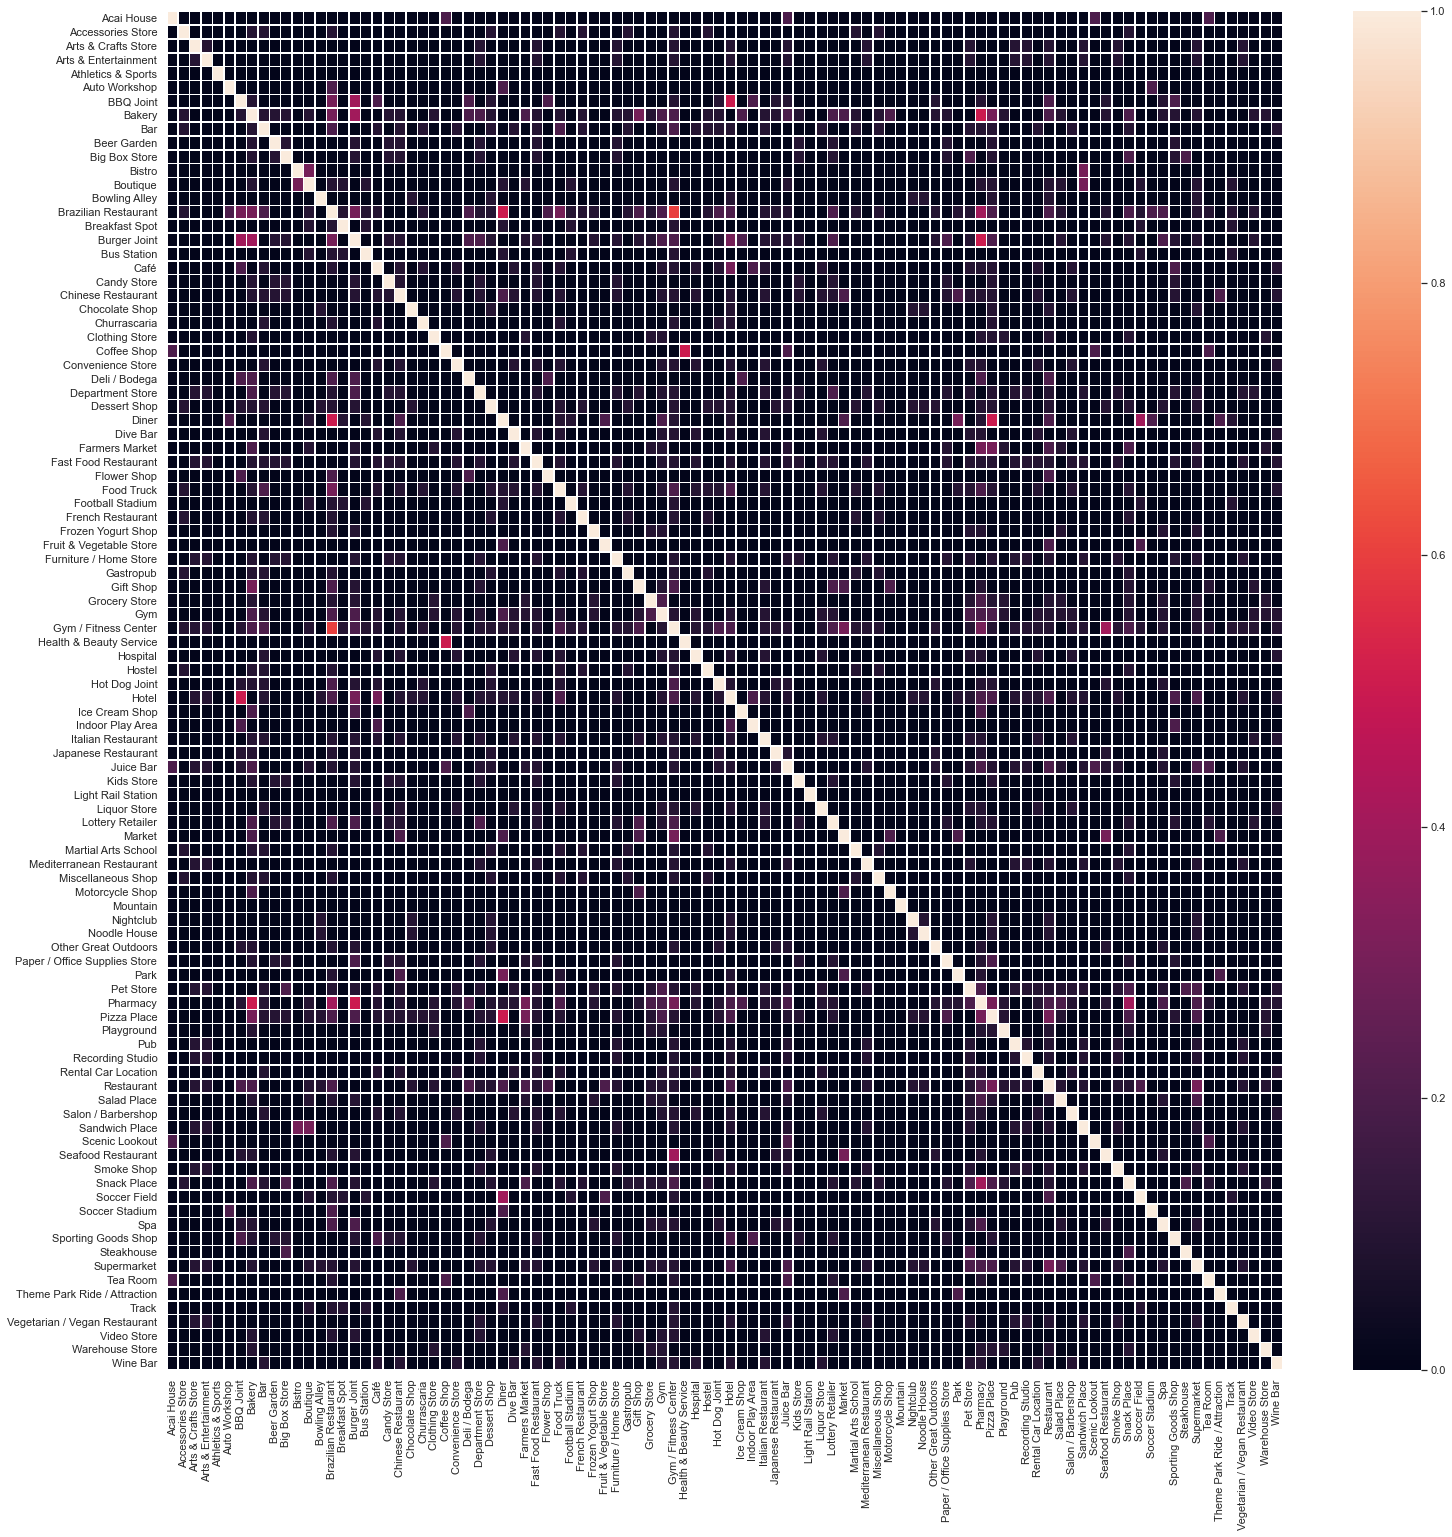

In [18]:
def histogram_intersection(a, b):

    v = np.minimum(a, b).sum().round(decimals=1)

    return v

correlacao = dt_grouped.corr(method=histogram_intersection)

fig, ax = plt.subplots(figsize=(25,25))
ax = sns.heatmap(correlacao,linewidths=.5)

corr = np.tril(correlacao)

num_top_venues = 5

for hood in dt_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = dt_grouped[dt_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dt_grouped['Neighborhood']

for ind in np.arange(dt_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dt_grouped.iloc[ind, :], num_top_venues)


In [21]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adhemar Garcia,Diner,Park,Theme Park Ride / Attraction,Chinese Restaurant,Market,Acai House,Motorcycle Shop,Pharmacy,Pet Store,Paper / Office Supplies Store
1,América,Pet Store,Hotel,Café,Salon / Barbershop,Rental Car Location,Pharmacy,Liquor Store,Italian Restaurant,Hospital,Gym / Fitness Center
2,Anita Garibaldi,Brazilian Restaurant,Football Stadium,Soccer Field,Breakfast Spot,Diner,Boutique,Gym / Fitness Center,Track,Bus Station,Park
3,Atiradores,Deli / Bodega,Brazilian Restaurant,Restaurant,BBQ Joint,Flower Shop,Pizza Place,Pharmacy,Pet Store,Park,Paper / Office Supplies Store
4,Aventureiro,Sandwich Place,Bistro,Boutique,Acai House,Miscellaneous Shop,Pharmacy,Pet Store,Park,Paper / Office Supplies Store,Other Great Outdoors
5,Boa Vista,Burger Joint,Italian Restaurant,Lottery Retailer,Department Store,Gift Shop,Gym,Gym / Fitness Center,Brazilian Restaurant,Bakery,Video Store
6,Boehmerwald,Brazilian Restaurant,Gym,Pet Store,Salad Place,Frozen Yogurt Shop,Burger Joint,Spa,Grocery Store,Pharmacy,Supermarket
7,Bom Retiro,Pharmacy,Juice Bar,Farmers Market,Restaurant,Salad Place,Bakery,Supermarket,Boutique,Pizza Place,Mountain
8,Bucarein,Juice Bar,Hotel,Smoke Shop,Gym / Fitness Center,Mediterranean Restaurant,Furniture / Home Store,Fast Food Restaurant,Pet Store,Department Store,Recording Studio
9,Centro,Hotel,Supermarket,Pizza Place,Restaurant,Chocolate Shop,Noodle House,Nightclub,Bowling Alley,Dessert Shop,Other Great Outdoors


In [22]:
a = neighborhoods_venues_sorted.describe()
a

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,36,36,36,36,36,36,36,36,36,36,36
unique,36,22,23,25,24,24,20,20,18,17,16
top,Bucarein,Bakery,Acai House,Miscellaneous Shop,Pharmacy,Pharmacy,Pet Store,Park,Pet Store,Other Great Outdoors,Other Great Outdoors
freq,1,5,5,5,6,5,6,6,7,6,7


In [23]:
# set number of clusters
kclusters = 12

dt_grouped_clustering = dt_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dt_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([ 0,  0,  0,  0, 11,  0,  0,  0,  0,  0])

In [24]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

dt_merged = df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
dt_merged = dt_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Bairro')

dt_merged # check the last columns!

,Bairro,Lat,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adhemar Garcia,-26.321731,-48.801844,0.0,Diner,Park,Theme Park Ride / Attraction,Chinese Restaurant,Market,Acai House,Motorcycle Shop,Pharmacy,Pet Store,Paper / Office Supplies Store
1,América,-26.290361,-48.853581,0.0,Pet Store,Hotel,Café,Salon / Barbershop,Rental Car Location,Pharmacy,Liquor Store,Italian Restaurant,Hospital,Gym / Fitness Center
2,Anita Garibaldi,-26.318420,-48.856278,0.0,Brazilian Restaurant,Football Stadium,Soccer Field,Breakfast Spot,Diner,Boutique,Gym / Fitness Center,Track,Bus Station,Park
3,Atiradores,-26.310171,-48.863780,0.0,Deli / Bodega,Brazilian Restaurant,Restaurant,BBQ Joint,Flower Shop,Pizza Place,Pharmacy,Pet Store,Park,Paper / Office Supplies Store
4,Aventureiro,-26.243548,-48.810468,11.0,Sandwich Place,Bistro,Boutique,Acai House,Miscellaneous Shop,Pharmacy,Pet Store,Park,Paper / Office Supplies Store,Other Great Outdoors
5,Boa Vista,-26.297986,-48.822423,0.0,Burger Joint,Italian Restaurant,Lottery Retailer,Department Store,Gift Shop,Gym,Gym / Fitness Center,Brazilian Restaurant,Bakery,Video Store
6,Boehmerwald,-26.363006,-48.828936,0.0,Brazilian Restaurant,Gym,Pet Store,Salad Place,Frozen Yogurt Shop,Burger Joint,Spa,Grocery Store,Pharmacy,Supermarket
7,Bom Retiro,-26.260933,-48.841919,0.0,Pharmacy,Juice Bar,Farmers Market,Restaurant,Salad Place,Bakery,Supermarket,Boutique,Pizza Place,Mountain
8,Bucarein,-26.314681,-48.838248,0.0,Juice Bar,Hotel,Smoke Shop,Gym / Fitness Center,Mediterranean Restaurant,Furniture / Home Store,Fast Food Restaurant,Pet Store,Department Store,Recording Studio
9,Centro,-26.171192,-50.391000,0.0,Hotel,Supermarket,Pizza Place,Restaurant,Chocolate Shop,Noodle House,Nightclub,Bowling Alley,Dessert Shop,Other Great Outdoors


In [25]:
dt_merged = dt_merged.dropna()

In [26]:
dt_merged["Cluster Labels"] = dt_merged["Cluster Labels"].astype(int)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
dt_merged

,Bairro,Lat,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adhemar Garcia,-26.321731,-48.801844,0,Diner,Park,Theme Park Ride / Attraction,Chinese Restaurant,Market,Acai House,Motorcycle Shop,Pharmacy,Pet Store,Paper / Office Supplies Store
1,América,-26.290361,-48.853581,0,Pet Store,Hotel,Café,Salon / Barbershop,Rental Car Location,Pharmacy,Liquor Store,Italian Restaurant,Hospital,Gym / Fitness Center
2,Anita Garibaldi,-26.318420,-48.856278,0,Brazilian Restaurant,Football Stadium,Soccer Field,Breakfast Spot,Diner,Boutique,Gym / Fitness Center,Track,Bus Station,Park
3,Atiradores,-26.310171,-48.863780,0,Deli / Bodega,Brazilian Restaurant,Restaurant,BBQ Joint,Flower Shop,Pizza Place,Pharmacy,Pet Store,Park,Paper / Office Supplies Store
4,Aventureiro,-26.243548,-48.810468,11,Sandwich Place,Bistro,Boutique,Acai House,Miscellaneous Shop,Pharmacy,Pet Store,Park,Paper / Office Supplies Store,Other Great Outdoors
5,Boa Vista,-26.297986,-48.822423,0,Burger Joint,Italian Restaurant,Lottery Retailer,Department Store,Gift Shop,Gym,Gym / Fitness Center,Brazilian Restaurant,Bakery,Video Store
6,Boehmerwald,-26.363006,-48.828936,0,Brazilian Restaurant,Gym,Pet Store,Salad Place,Frozen Yogurt Shop,Burger Joint,Spa,Grocery Store,Pharmacy,Supermarket
7,Bom Retiro,-26.260933,-48.841919,0,Pharmacy,Juice Bar,Farmers Market,Restaurant,Salad Place,Bakery,Supermarket,Boutique,Pizza Place,Mountain
8,Bucarein,-26.314681,-48.838248,0,Juice Bar,Hotel,Smoke Shop,Gym / Fitness Center,Mediterranean Restaurant,Furniture / Home Store,Fast Food Restaurant,Pet Store,Department Store,Recording Studio
9,Centro,-26.171192,-50.391000,0,Hotel,Supermarket,Pizza Place,Restaurant,Chocolate Shop,Noodle House,Nightclub,Bowling Alley,Dessert Shop,Other Great Outdoors


In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dt_merged['Lat'], dt_merged['Long'], dt_merged['Bairro'], dt_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [29]:
dt_merged.loc[dt_merged['Cluster Labels'] == 0, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adhemar Garcia,Diner,Park,Theme Park Ride / Attraction,Chinese Restaurant,Market,Acai House,Motorcycle Shop,Pharmacy,Pet Store,Paper / Office Supplies Store
1,América,Pet Store,Hotel,Café,Salon / Barbershop,Rental Car Location,Pharmacy,Liquor Store,Italian Restaurant,Hospital,Gym / Fitness Center
2,Anita Garibaldi,Brazilian Restaurant,Football Stadium,Soccer Field,Breakfast Spot,Diner,Boutique,Gym / Fitness Center,Track,Bus Station,Park
3,Atiradores,Deli / Bodega,Brazilian Restaurant,Restaurant,BBQ Joint,Flower Shop,Pizza Place,Pharmacy,Pet Store,Park,Paper / Office Supplies Store
5,Boa Vista,Burger Joint,Italian Restaurant,Lottery Retailer,Department Store,Gift Shop,Gym,Gym / Fitness Center,Brazilian Restaurant,Bakery,Video Store
6,Boehmerwald,Brazilian Restaurant,Gym,Pet Store,Salad Place,Frozen Yogurt Shop,Burger Joint,Spa,Grocery Store,Pharmacy,Supermarket
7,Bom Retiro,Pharmacy,Juice Bar,Farmers Market,Restaurant,Salad Place,Bakery,Supermarket,Boutique,Pizza Place,Mountain
8,Bucarein,Juice Bar,Hotel,Smoke Shop,Gym / Fitness Center,Mediterranean Restaurant,Furniture / Home Store,Fast Food Restaurant,Pet Store,Department Store,Recording Studio
9,Centro,Hotel,Supermarket,Pizza Place,Restaurant,Chocolate Shop,Noodle House,Nightclub,Bowling Alley,Dessert Shop,Other Great Outdoors
11,Costa e Silva,Bakery,Pizza Place,Snack Place,Pharmacy,Grocery Store,Gym,Restaurant,Clothing Store,Farmers Market,Playground


In [30]:
dt_merged.loc[dt_merged['Cluster Labels'] == 1, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Comasa,Pizza Place,Diner,Playground,Pharmacy,Pet Store,Park,Paper / Office Supplies Store,Other Great Outdoors,Noodle House,Nightclub
16,Guanabara,Pizza Place,Diner,Gym,Miscellaneous Shop,Pharmacy,Pet Store,Park,Paper / Office Supplies Store,Other Great Outdoors,Noodle House


In [31]:
dt_merged.loc[dt_merged['Cluster Labels'] == 2, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,Ulysses Guimarães,Bakery,Acai House,Miscellaneous Shop,Pizza Place,Pharmacy,Pet Store,Park,Paper / Office Supplies Store,Other Great Outdoors,Noodle House


In [32]:
dt_merged.loc[dt_merged['Cluster Labels'] == 3, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Parque Guarani,Market,Acai House,Miscellaneous Shop,Pharmacy,Pet Store,Park,Paper / Office Supplies Store,Other Great Outdoors,Noodle House,Nightclub


In [33]:
dt_merged.loc[dt_merged['Cluster Labels'] == 4, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Nova Brasília,Boutique,Miscellaneous Shop,Pizza Place,Pharmacy,Pet Store,Park,Paper / Office Supplies Store,Other Great Outdoors,Noodle House,Nightclub


In [34]:
dt_merged.loc[dt_merged['Cluster Labels'] == 5, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Jativoca,Light Rail Station,Acai House,Miscellaneous Shop,Pharmacy,Pet Store,Park,Paper / Office Supplies Store,Other Great Outdoors,Noodle House,Nightclub


In [35]:
dt_merged.loc[dt_merged['Cluster Labels'] == 6, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Morro do Meio,Mountain,Acai House,Playground,Pharmacy,Pet Store,Park,Paper / Office Supplies Store,Other Great Outdoors,Noodle House,Nightclub


In [36]:
dt_merged.loc[dt_merged['Cluster Labels'] == 7, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Vila Cubatão,Athletics & Sports,Acai House,Miscellaneous Shop,Pizza Place,Pharmacy,Pet Store,Park,Paper / Office Supplies Store,Other Great Outdoors,Noodle House


In [37]:
dt_merged.loc[dt_merged['Cluster Labels'] == 8, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Glória,Hotel,BBQ Joint,Café,Sporting Goods Shop,Indoor Play Area,Track,Pizza Place,Pet Store,Park,Paper / Office Supplies Store
19,Itinga,Hotel,BBQ Joint,Burger Joint,Motorcycle Shop,Pizza Place,Pharmacy,Pet Store,Park,Paper / Office Supplies Store,Other Great Outdoors


In [38]:
dt_merged.loc[dt_merged['Cluster Labels'] == 9, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,João Costa,Coffee Shop,Health & Beauty Service,Miscellaneous Shop,Pizza Place,Pharmacy,Pet Store,Park,Paper / Office Supplies Store,Other Great Outdoors,Noodle House


In [39]:
dt_merged.loc[dt_merged['Cluster Labels'] == 10, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Profipo,Soccer Field,Diner,Restaurant,Fruit & Vegetable Store,Miscellaneous Shop,Pet Store,Park,Paper / Office Supplies Store,Other Great Outdoors,Noodle House


In [40]:
dt_merged.loc[dt_merged['Cluster Labels'] == 11, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Aventureiro,Sandwich Place,Bistro,Boutique,Acai House,Miscellaneous Shop,Pharmacy,Pet Store,Park,Paper / Office Supplies Store,Other Great Outdoors


In [182]:
pop=pd.read_csv("Populacao.csv")

In [183]:
pop.head()

,Bairro,População
0,Aventureiro,34878
1,Paranaguá-mirim,27728
2,Costa e Silva,27425
3,Jardim-iririú,22756
4,Iririu,22344


<AxesSubplot:xlabel='Bairro'>

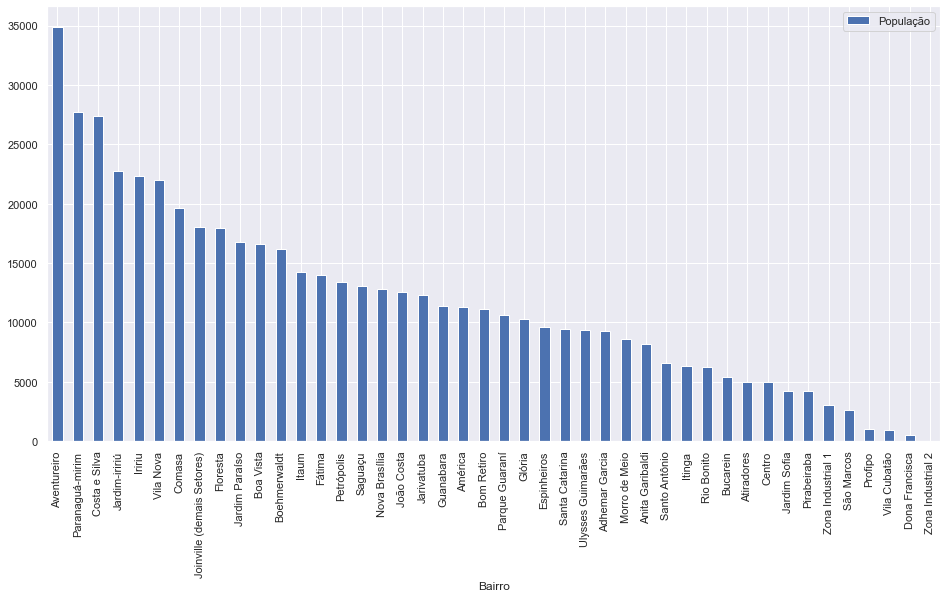

In [184]:
pop.plot(x ='Bairro', y='População', kind="bar", figsize=(16,8))

In [185]:
dt_merged

,Bairro,Lat,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adhemar Garcia,-26.321731,-48.801844,0,Diner,Park,Theme Park Ride / Attraction,Chinese Restaurant,Market,Acai House,Motorcycle Shop,Pharmacy,Pet Store,Paper / Office Supplies Store
1,América,-26.290361,-48.853581,0,Pet Store,Hotel,Café,Salon / Barbershop,Rental Car Location,Pharmacy,Liquor Store,Italian Restaurant,Hospital,Gym / Fitness Center
2,Anita Garibaldi,-26.318420,-48.856278,0,Brazilian Restaurant,Football Stadium,Soccer Field,Breakfast Spot,Diner,Boutique,Gym / Fitness Center,Track,Bus Station,Park
3,Atiradores,-26.310171,-48.863780,0,Deli / Bodega,Brazilian Restaurant,Restaurant,BBQ Joint,Flower Shop,Pizza Place,Pharmacy,Pet Store,Park,Paper / Office Supplies Store
4,Aventureiro,-26.243548,-48.810468,11,Sandwich Place,Bistro,Boutique,Acai House,Miscellaneous Shop,Pharmacy,Pet Store,Park,Paper / Office Supplies Store,Other Great Outdoors
5,Boa Vista,-26.297986,-48.822423,0,Burger Joint,Italian Restaurant,Lottery Retailer,Department Store,Gift Shop,Gym,Gym / Fitness Center,Brazilian Restaurant,Bakery,Video Store
6,Boehmerwald,-26.363006,-48.828936,0,Brazilian Restaurant,Gym,Pet Store,Salad Place,Frozen Yogurt Shop,Burger Joint,Spa,Grocery Store,Pharmacy,Supermarket
7,Bom Retiro,-26.260933,-48.841919,0,Pharmacy,Juice Bar,Farmers Market,Restaurant,Salad Place,Bakery,Supermarket,Boutique,Pizza Place,Mountain
8,Bucarein,-26.314681,-48.838248,0,Juice Bar,Hotel,Smoke Shop,Gym / Fitness Center,Mediterranean Restaurant,Furniture / Home Store,Fast Food Restaurant,Pet Store,Department Store,Recording Studio
9,Centro,-26.171192,-50.391000,0,Hotel,Supermarket,Pizza Place,Restaurant,Chocolate Shop,Noodle House,Nightclub,Bowling Alley,Dessert Shop,Other Great Outdoors


In [186]:
palavras = []
for index, row in dt_merged.iterrows():
    palavras.append(row['1st Most Common Venue'])
    palavras.append(row['2nd Most Common Venue'])
    palavras.append(row["3rd Most Common Venue"])
    palavras.append(row["4th Most Common Venue"])
    palavras.append(row["5th Most Common Venue"])
    palavras.append(row["6th Most Common Venue"])
    palavras.append(row["7th Most Common Venue"])
    palavras.append(row["8th Most Common Venue"])
    palavras.append(row["9th Most Common Venue"])
    palavras.append(row["10th Most Common Venue"])

In [191]:
df_venues_count = pd.DataFrame(palavras)

In [194]:
df_venues_count = pd.DataFrame(df_venues_count.value_counts())

<AxesSubplot:xlabel='0'>

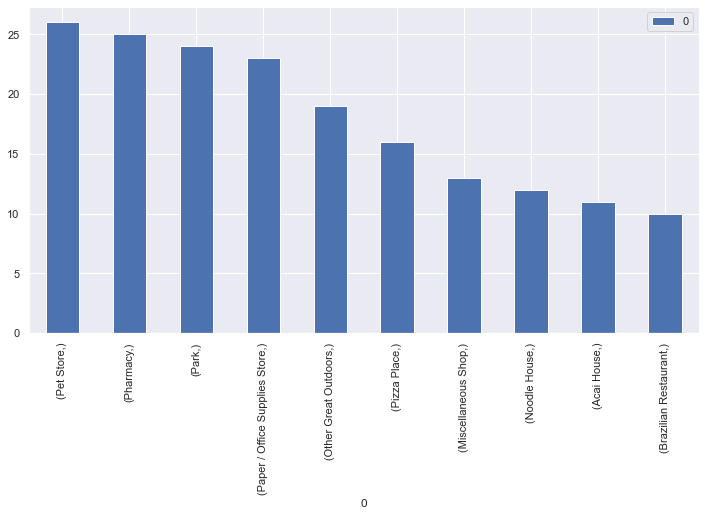

In [211]:
top_10_venues = df_venues_count.head(10)
top_10_venues.plot(kind="bar", figsize=(12,6))

<AxesSubplot:xlabel='0'>

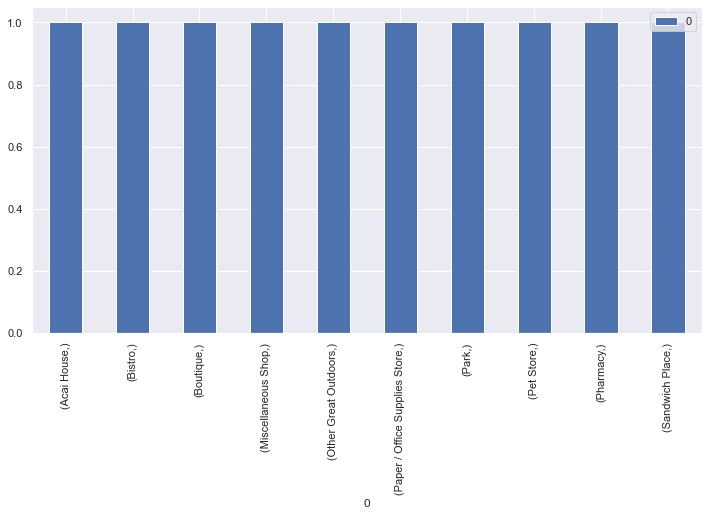

In [223]:
palavras2 = []
for index, row in dt_merged[dt_merged["Bairro"]=="Aventureiro"].iterrows():
    palavras2.append(row['1st Most Common Venue'])
    palavras2.append(row['2nd Most Common Venue'])
    palavras2.append(row["3rd Most Common Venue"])
    palavras2.append(row["4th Most Common Venue"])
    palavras2.append(row["5th Most Common Venue"])
    palavras2.append(row["6th Most Common Venue"])
    palavras2.append(row["7th Most Common Venue"])
    palavras2.append(row["8th Most Common Venue"])
    palavras2.append(row["9th Most Common Venue"])
    palavras2.append(row["10th Most Common Venue"])
    
df_venues_count_aventureiro = pd.DataFrame(palavras2)
df_venues_count_aventureiro = pd.DataFrame(df_venues_count_aventureiro.value_counts())

top_10_venues_aventureiro = df_venues_count_aventureiro.head(10)
top_10_venues_aventureiro.plot(kind="bar", figsize=(12,6))

<AxesSubplot:xlabel='0'>

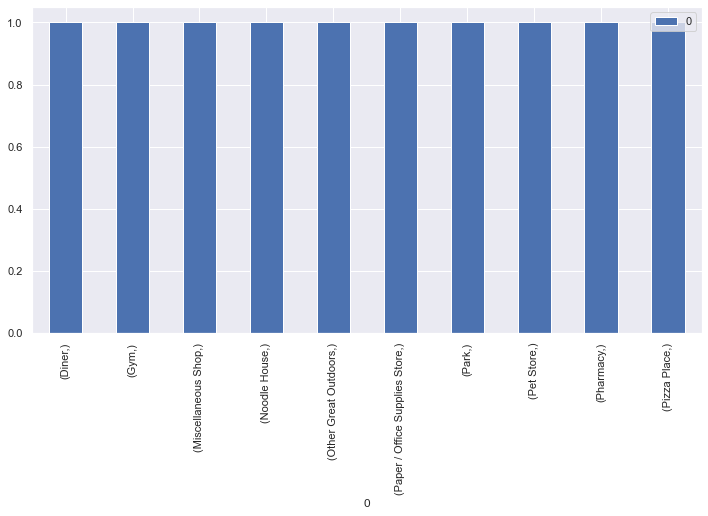

In [225]:
palavras3 = []
for index, row in dt_merged[dt_merged["Bairro"]=="Guanabara"].iterrows():
    palavras3.append(row['1st Most Common Venue'])
    palavras3.append(row['2nd Most Common Venue'])
    palavras3.append(row["3rd Most Common Venue"])
    palavras3.append(row["4th Most Common Venue"])
    palavras3.append(row["5th Most Common Venue"])
    palavras3.append(row["6th Most Common Venue"])
    palavras3.append(row["7th Most Common Venue"])
    palavras3.append(row["8th Most Common Venue"])
    palavras3.append(row["9th Most Common Venue"])
    palavras3.append(row["10th Most Common Venue"])
    
df_venues_count_Guanabara = pd.DataFrame(palavras3)
df_venues_count_Guanabara = pd.DataFrame(df_venues_count_Guanabara.value_counts())

top_10_venues_Guanabara = df_venues_count_Guanabara.head(10)
top_10_venues_Guanabara.plot(kind="bar", figsize=(12,6))

<AxesSubplot:xlabel='0'>

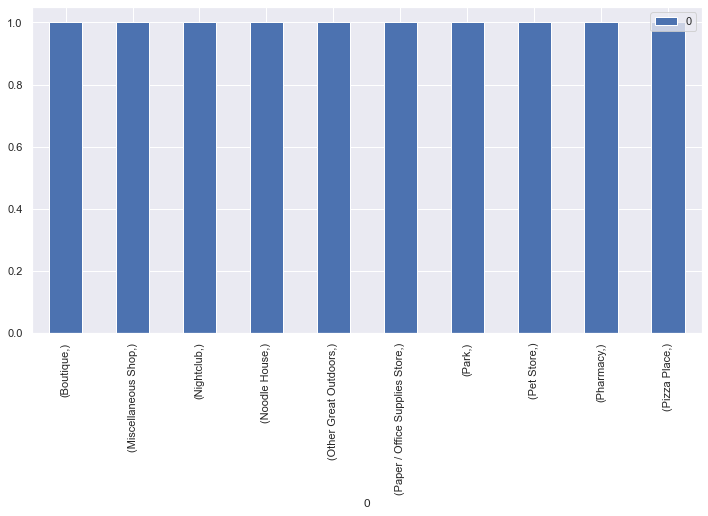

In [226]:
palavras4 = []
for index, row in dt_merged[dt_merged["Bairro"]=="Nova Brasília"].iterrows():
    palavras4.append(row['1st Most Common Venue'])
    palavras4.append(row['2nd Most Common Venue'])
    palavras4.append(row["3rd Most Common Venue"])
    palavras4.append(row["4th Most Common Venue"])
    palavras4.append(row["5th Most Common Venue"])
    palavras4.append(row["6th Most Common Venue"])
    palavras4.append(row["7th Most Common Venue"])
    palavras4.append(row["8th Most Common Venue"])
    palavras4.append(row["9th Most Common Venue"])
    palavras4.append(row["10th Most Common Venue"])
    
df_venues_count_Nova_Brasilia = pd.DataFrame(palavras4)
df_venues_count_Nova_Brasilia = pd.DataFrame(df_venues_count_Nova_Brasilia.value_counts())

top_10_venues_Nova_Brasilia = df_venues_count_Nova_Brasilia.head(10)
top_10_venues_Nova_Brasilia.plot(kind="bar", figsize=(12,6))